In [1]:
# imports for this notebook
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pystan
from theano import tensor as tt
import pymc3
import scipy.stats as stats

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
sns.set_style("whitegrid")
sns.set_context("poster")

/Users/nickhoernle/anaconda2/envs/ipython3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# First we generate some data from mixture of normals

In [295]:
prior_probabilities = [0.2,0.3,0.2,0.3]
mus = [[-1,1],[1,1],[1,-1],[-1,-1]]
sigma = [[0.2,0],[0,0.2]]

data = []
clusters = []
for i in range(1000):
    zi = np.random.choice([0,1,2,3],p=prior_probabilities) 
    clusters.append(zi)
    data.append(np.random.multivariate_normal(mus[zi], sigma))
    
data = np.array(data)

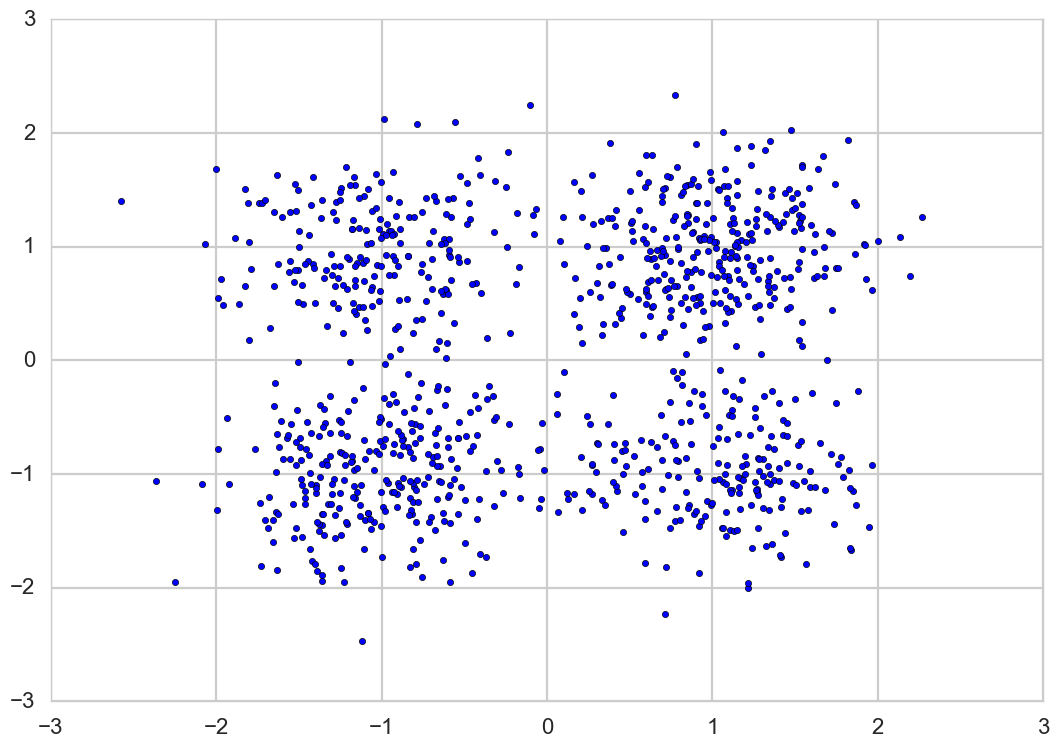

In [297]:
plt.scatter(data[:,0], data[:,1])

### Define the stan model for inference

In [298]:
model_code = '''
data{
  int<lower=0> L;      // maximum number of clusters
  int<lower=0> N;      // amount of data
  
  vector[2] y[N];       // data observations  
  real<lower=0> alpha; // concentration parameter
}

parameters {
  vector[2] mu[L];                   // mean for each of the clusters   
  //real<lower=0> sigma;          // variance for the clusters
  real<lower=0,upper=1> V[L-1]; // volume that is broken off at each sick breaking
}

transformed parameters{
  simplex[L] pi;                // mass associated with each cluster
  pi[1] = V[1];
  {
      // break a stick for the remaining clusters

      vector[L-1] remaining_portion; 
      remaining_portion[1] = 1;

      for(i in 2:(L-1)){
          remaining_portion[i] = (1-V[i-1]) * remaining_portion[i-1];
          pi[i] = V[i] * remaining_portion[i];
      }
  }
  pi[L]=(1-sum(pi[1:L-1]));  // the final piece is the mass left over
}

model {
    vector[L] ps;
    
    //sigma ~ cauchy(0,1);
    
    for (l in 1:L) { mu[l] ~ normal(0,5); }
    
    // stick breaking prior
    V ~ beta(1,alpha);
  
    for(i in 1:N) {
        
        // here we are marginalizing out the z's
        for (l in 1:L) {
            ps[l] = log(pi[l]) + multi_normal_lpdf(y[i] | mu[l], [[0.2,0],[0,0.2]]);
        }
        target += log_sum_exp(ps);
    }
}

generated quantities {
    real z[N];
    real max_p;
    real ps;
    for (i in 1:N) {
    
      max_p = negative_infinity();
      for (j in 1:L){
        ps = multi_normal_lpdf(y[i] | mu[j], [[0.2,0],[0,0.2]]);
        if (ps > max_p) {
          max_p = ps;
          z[i] = j;
        }
      }
    
    }
}
'''

In [299]:
model=pystan.StanModel(model_code=model_code, )

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a3ebb6a4c36e53f72a98e6d42dc0b962 NOW.


In file included from /var/folders/3s/j7n5q0y13s50l2xccn51fnph0000gn/T/tmppjhxjis7/stanfit4anon_model_a3ebb6a4c36e53f72a98e6d42dc0b962_2951169361529148866.cpp:599:
In file included from /Users/nickhoernle/anaconda2/envs/ipython3/lib/python3.5/site-packages/numpy/core/include/numpy/arrayobject.h:4:
In file included from /Users/nickhoernle/anaconda2/envs/ipython3/lib/python3.5/site-packages/numpy/core/include/numpy/ndarrayobject.h:18:
In file included from /Users/nickhoernle/anaconda2/envs/ipython3/lib/python3.5/site-packages/numpy/core/include/numpy/ndarraytypes.h:1816:
/Users/nickhoernle/anaconda2/envs/ipython3/lib/python3.5/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:15:2: warning: "Using deprecated NumPy API, disable it by "          "#defining NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, disable it by " \
 ^
/var/folders/3s/j7n5q0y13s50l2xccn51fnph0000gn/T/tmppjhxjis7/stanfit4anon_model_a3ebb6a4c36e53f72a98e6d42dc

In [300]:
stan_data = {
    'L': 10,
    'N': len(data),
    'y': data,
    'alpha': 1,
}

In [301]:
fit = model.sampling(data=stan_data, warmup=4000, thin=2, iter=6000, chains=1)

/Users/nickhoernle/anaconda2/envs/ipython3/lib/python3.5/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


### Look at the fit and the traceplots

In [302]:
fit

Inference for Stan model: anon_model_a3ebb6a4c36e53f72a98e6d42dc0b962.
1 chains, each with iter=6000; warmup=4000; thin=2; 
post-warmup draws per chain=1000, total post-warmup draws=1000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0,0]   0.99  9.0e-4   0.03   0.94   0.98   0.99   1.01   1.05    909    1.0
mu[1,0]  -1.01  8.8e-4   0.03  -1.07  -1.03  -1.01  -0.99  -0.96    995    1.0
mu[2,0]  -1.04  1.1e-3   0.03  -1.11  -1.06  -1.04  -1.02  -0.98    840    1.0
mu[3,0]   1.03  1.1e-3   0.04   0.97   1.01   1.03   1.06   1.11    959    1.0
mu[4,0] 5.0e-3    0.14   4.48  -9.38  -2.26  -0.03   2.62   8.95   1000    1.0
mu[5,0]  -0.03    0.16   4.48  -9.26  -2.81  -0.07   2.64   9.37    810    1.0
mu[6,0]   0.29    0.17   4.74  -9.07  -2.79   0.08   3.62   9.38    825    1.0
mu[7,0]   0.04    0.15   4.77  -9.37  -3.02   0.07   3.16   9.62   1000    1.0
mu[8,0]  -0.04    0.16   4.87  -9.69  -3.31   0.04   3.29   9.33    936    1.0
mu[9,0]  -0.12    0.1

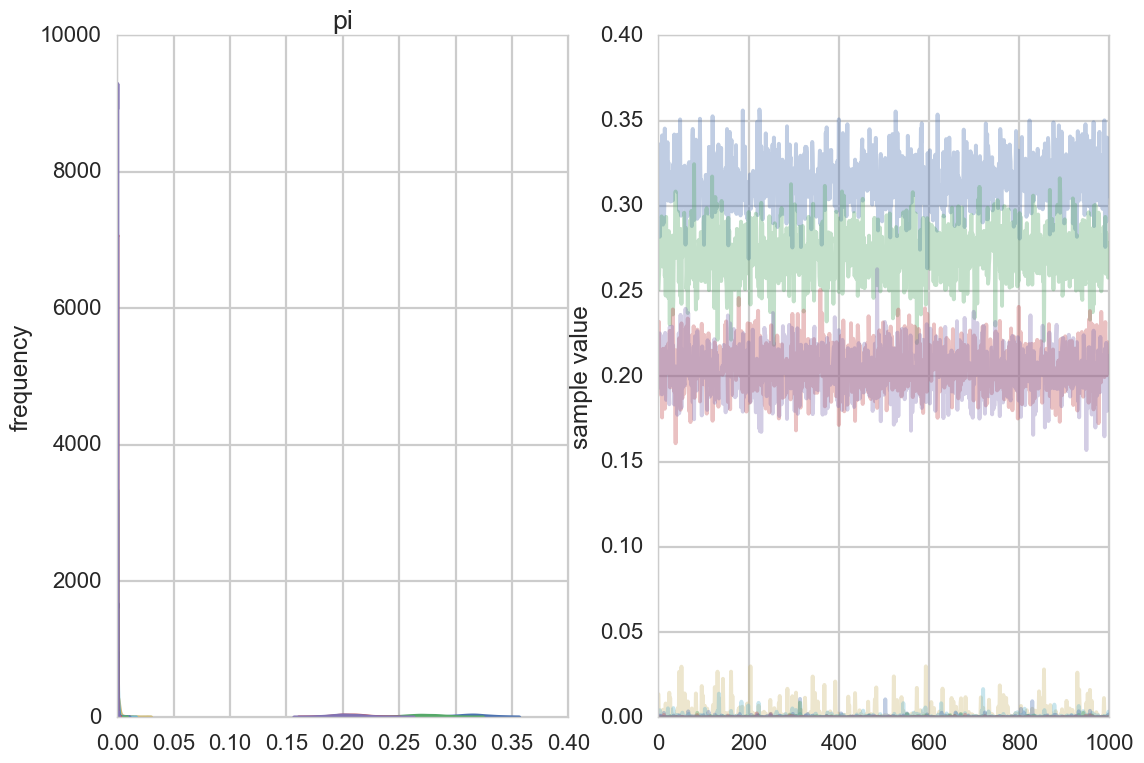

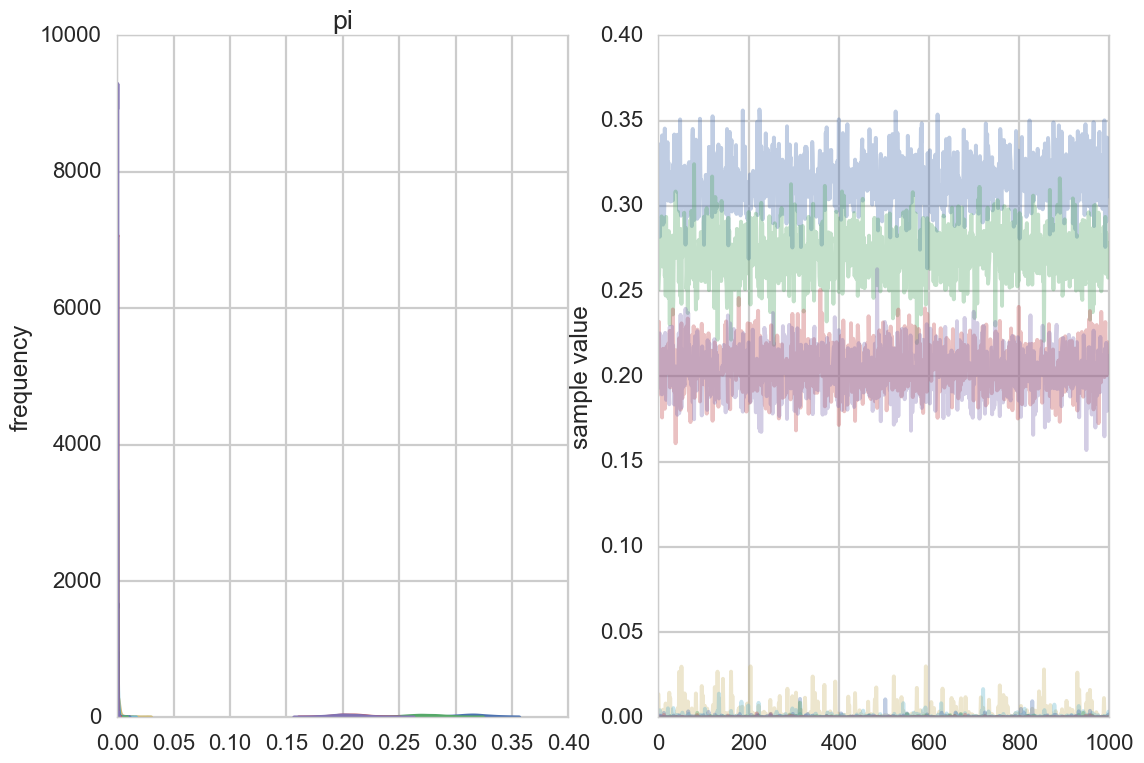

In [303]:
fit.traceplot('pi')

In [304]:
la = fit.extract(permuted=True)

In [305]:
label = []
sample = []

for pi,samples in enumerate(la.get('pi').T):
    for s in samples:
        label.append('pi%i'%pi)
        sample.append(s)

In [306]:
la.get('pi').T.shape

(10, 1000)

In [307]:
df = pd.DataFrame()
df['label'] = pd.Categorical(label)
df['sample'] = sample

In [308]:
df.head(2)

,label,sample
0,pi0,0.336285
1,pi0,0.286463


# Get the cluster specific paramters

/Users/nickhoernle/anaconda2/envs/ipython3/lib/python3.5/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


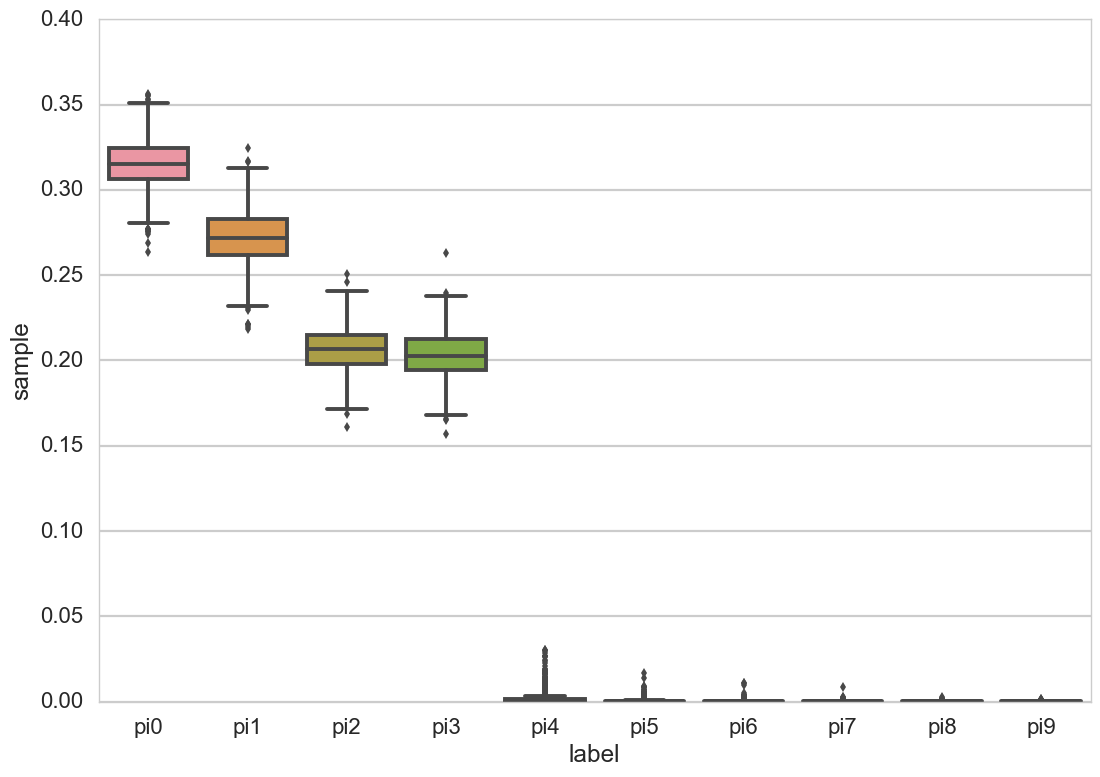

In [309]:
sns.boxplot(x='label', y='sample', data=df)
plt.show()

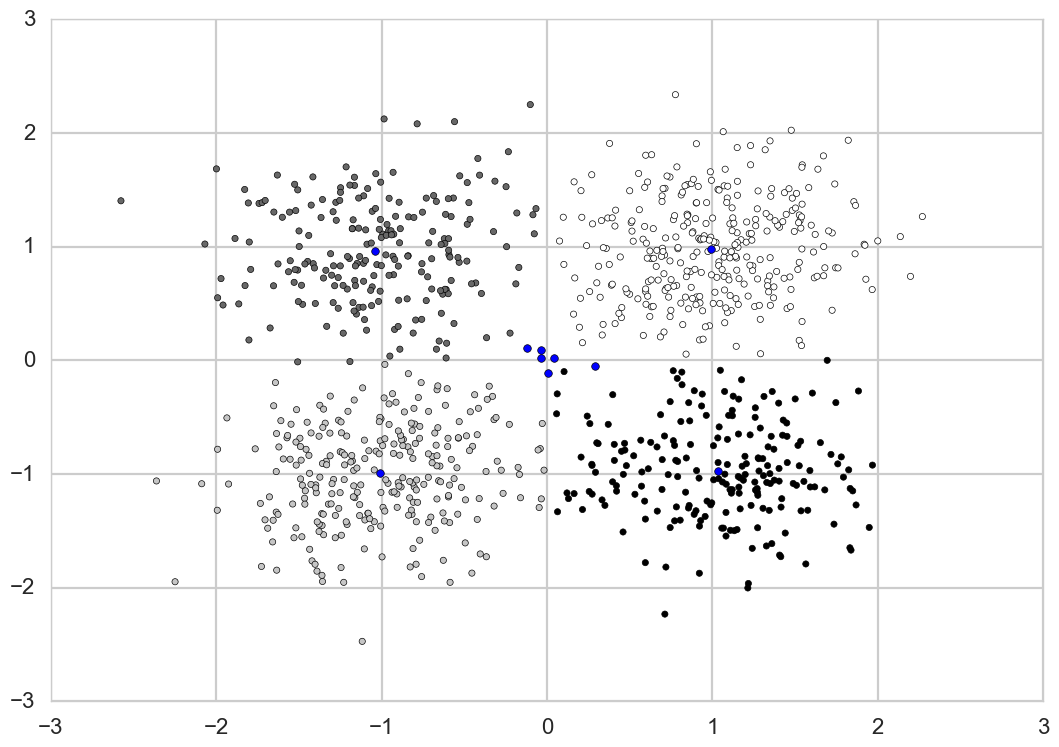

In [323]:
cluster_means = la.get('mu').mean(axis=0)

plt.scatter(data[:,0], data[:,1], c=np.median(la.get('z'), axis=0))
plt.scatter(cluster_means[:,0], cluster_means[:,1], c='b', s=30)

plt.show()

# HDP-HMM from Fox (2007)

In [1274]:
# choose initial state
means = [50,0,-50]
var = [50,10,50]
T =500
ps = [[0.97,0.015,0.015], [0.015,0.97,0.015],[0.015,0.015,0.97]]

zis = []
y=[]
for i in range(T):
    
    if i == 0:
        zi = np.random.choice([0,1,2], p=[0.33,0.33,0.34])
    else:
        zi = np.random.choice([0,1,2], p=ps[zis[i-1]])
    
    zis.append(zi)
    y.append(np.random.normal(means[zi], np.sqrt(var[zi])))

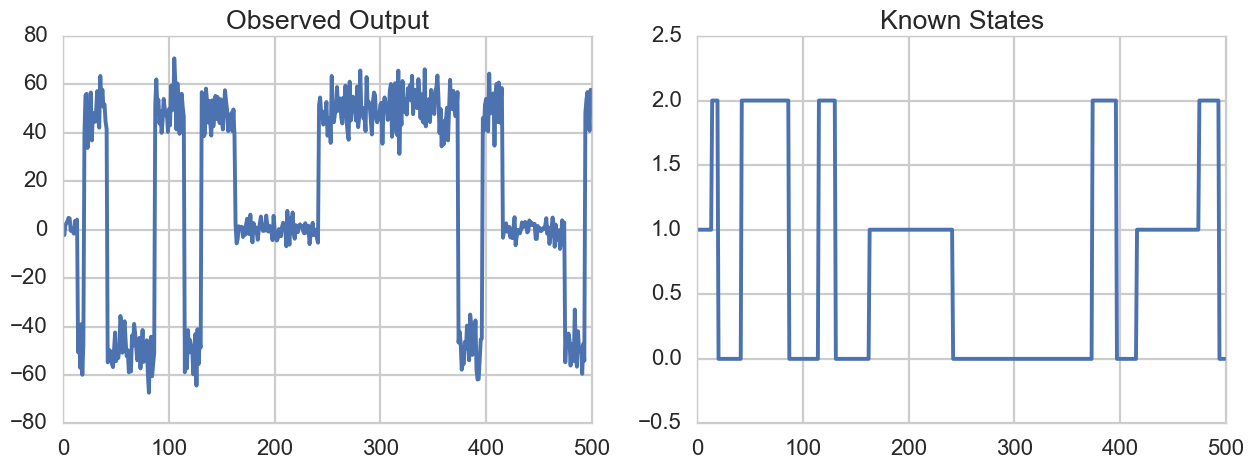

In [1275]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))

ax1.plot(y)
ax2.plot(zis)

ax2.set_ylim([-0.5,2.5])


ax1.set_title('Observed Output')
ax2.set_title('Known States')

plt.show()

### Follow Fox for Blocked Gibbs sampler for tempered HDP-HMM 

#### Step 1:
Set $\pi = \pi^{(n-1)}$ and $\theta = \theta^{(n-1)}$. Working sequentially backwards in time, for each $t \in [T,\dots,1]$ calculate the messages $m_{t,t-1}(k)$:

   a) For each $k \in [1,\dots,L]$, initialize messages to 
    $$m_{T+1,T}(k) = 1$$
   b) For each $k \in [1,\dots,L]$, compute 
    $$m_{t,t-1}(k)=\sum\limits_{j=1}^{L}\pi_k(j)\mathcal{N}(y_t ; \mu_j, \Sigma_j)m_{t+1,t}(j)$$

In [1276]:
def backward_step(obs, likeihood_fn, pi_k, m_tplus1, theta, L):
    '''
    The backward message that is passed from zt to zt-1 given by the HMM:
        P(y1:T \mid z_{t-1}, \pi, \theta)
    '''
    message = np.float128(0)
    for j in range(L):
        message += np.exp(np.log(pi_k[j]) + likeihood_fn(*theta[j]).logpdf(obs) + np.log(m_tplus1[j]))
    return message
    
    
def backward_algorithm(Y, params, **kwargs):
    '''
    Calculate the backward messages for all time T...1
    '''
    
    pi = params['pi']
    theta = params['theta']
    L,T = params['L'],params['T']
    
    
    # we have L models and T time steps
    bkwd = np.zeros(shape=(T+1, L), dtype=np.float128)
    # (a) set the messages T+1,T t
    bkwd[-1,:] = 1
    
    # (b) compute the backward messages
    for tf, yt in enumerate(Y):
        
        t = (T-1)-tf # we need the reverse index
        for k in range(L):
            bkwd[t,k] = backward_step(yt, stats.norm, pi[k], bkwd[t+1], theta, L)
    
    return bkwd

In [1277]:
params = {}
params['pi'] = [[0.95,0.05],[0.05,0.95]]
params['theta'] = [[1,0.5],[-1,0.5]]
params['L'] = len(params['pi'])
Y = [0.5,0.5,-0.5,-0.5,-1,1,1,1.5,0.5]
params['Y'] = Y
params['T'] = len(Y)
params['alpha'] = 1
params['beta'] = np.random.dirichlet(np.ones(params['L']))
params['kappa'] = 1
params['gamma'] = 1

In [1278]:
bkwd_messages = backward_algorithm(Y, params)
bkwd_messages

array([[1.19061786e-05, 6.38086007e-07],
       [2.58960744e-05, 1.36295964e-06],
       [5.63271141e-05, 2.96569639e-06],
       [7.43110473e-05, 4.38310138e-06],
       [9.80040685e-05, 1.86137136e-03],
       [1.46524545e-04, 2.45566378e-03],
       [2.05772295e-03, 5.33938412e-03],
       [2.11583099e-01, 1.14098485e-02],
       [4.60187561e-01, 3.26175844e-02],
       [1.00000000e+00, 1.00000000e+00]], dtype=float128)

#### Step 2:
Sample state assignments $z_{1:T}$ working sequentially forward in time, starting with $n_{jk} = 0$ and $\mathcal{Y}_k = \emptyset$ for each $(j,k) \in \{1,\dots,L\}^2$:

a) For each $k \in \{1,\dots,L\}$, compute the probability:
$$ f_k(y_t) = \pi_{z_{t-1}}(k)\mathcal{N}(y_t, \mu_k, \Sigma_k) m_{t+1,t}(k) $$

b) Sample a state assignment $z_t$:
$$z_t \sim \sum_{k=1}^{L}f_k(y_t)\delta(z_t,k)$$

c) Increment $n_{z_{t-1},z_t}$ and add $y_t$ to the cached statistics for the new assignment $z_t = k$:
$$\mathcal{Y} \rightarrow \mathcal{Y}_k \bigoplus y_t$$

In [1279]:
def forward_step(obs, likeihood_fn, pi_ztmin1, m_tplus1, theta, L, k):
    '''
    The backward message that is passed from zt to zt-1 given by the HMM:
        P(y1:T \mid z_{t-1}, \pi, \theta)
    '''
    
    prob = np.exp(np.log(pi_ztmin1[k]) + likeihood_fn(*theta[k]).logpdf(obs) + np.log(m_tplus1[k]))
    return prob

def state_assignments(Y, bkwd, params, **kwargs):
    '''
    Sample the state assignment for z 1 to T and update the sets Y_k accordingly
    '''
    
    pi = params['pi']
    theta = params['theta']
    L,T = params['L'],params['T']
    
    # start with n_{jk} = 0
    n = np.zeros(shape=(L,L), dtype=np.int16)
    
    options = np.arange(0,L,dtype=np.int16)
    # starting state assignment 
    # TODO: Is this correct?????
    z_tmin1 = np.argmax(bkwd[0])
    z = np.zeros(shape=T, dtype=np.int16)
    Yk = {}

    for t, yt in enumerate(Y):
        
        prob_fk = np.zeros(shape=L, dtype=np.float128)
        for k in range(L): 
            
            # (a) compute the probability f_k(yt)
            prob_fk[k] = forward_step(yt, stats.norm, pi[z_tmin1], bkwd[t], theta, L, k)
            
        # (b) sample a new z_t
        # normalize prob_fk (TODO is this correct?????)
        prob_fk_ = np.array(prob_fk/np.sum(prob_fk), dtype=np.float64)
        z[t] = np.random.choice(options, p=prob_fk_)

        # (c) increment n
        n[z_tmin1, z[t]] += 1
        
        # cache y_t (not yet sure of what the eff this is for)
        if z[t] in Yk:
            Yk[z[t]].append(yt)
        else:
            Yk[z[t]] = [yt]
            
        z_tmin1 = z[t]
        
    return {
        'z': z,
        'Yk': Yk,
        'n': n
    }

In [1280]:
state_par = state_assignments(Y, bkwd_messages, params)
z = state_par['z']
Yk = state_par['Yk']
n = state_par['n']
state_par

{'Yk': {0: [0.5, 0.5, -0.5, 1, 1, 1.5, 0.5], 1: [-0.5, -1]},
 'n': array([[6, 1],
        [1, 1]], dtype=int16),
 'z': array([0, 0, 0, 1, 1, 0, 0, 0, 0], dtype=int16)}

#### Step 3:
Sample the auxiliary variables $m$, $w$, $\bar{m}$:

a) for each $(j,k) \in [1, \dots, L]^2$, define $\mathcal{J}_{jk} = \{ \tau \mid z_{\tau-1} = j, z_{\tau} = k \}$. Set $m_{jk} = 0$ and $n = 0$ and for each $\tau \in \mathcal{J}_{jk}$, sample:

$$ 
x \sim Bern(\frac{\alpha \beta_k + \kappa \delta(j,k)}{n + \alpha \beta_k + \kappa \delta(j,k)})
$$

Increment $n$ and if $x=1$, increment $m_{jk}$

b) For each $j \in \{1, \dots, L \}$, sample the number of override variables in restaurant $j$:
$$
m_{j.} \sim Binomial(m_{jj}, \frac{\rho}{rho + \beta_j(1-\rho)}
$$

Where $\rho = \frac{\kappa}{\alpha + \kappa}$ (prior that $w_{jt} = 1$). Note too that $w_{j.} = \sum_t w_{jt}

In [1281]:
def step_3(state_assignments, params):
    L = params['L']
    alpha = params['alpha']
    kappa = params['kappa']
    beta = params['beta']
    z = state_assignments['z']

    m = np.zeros(shape=(L,L), dtype=np.int16)

    J = [[[] for i in range(L)] for i in range(L)]

    for t, zt in enumerate(z):
        if t == 0:
            None
        else:
            J[z[t-1]][zt].append(t) 


    for j in range(1, L):
        for k in range(1, L):

            n = 0
            for i in J[j][k]:
                prob = (alpha*beta[k] + kappa)/(n + alpha*beta[k] + kappa)
                x = np.random.binomial(n=1, p=prob)
                m[j,k] += x
                n += 1
                
    ##############
    # STEP (b)
    ##############
    rho = kappa/(alpha + kappa)
    w = np.zeros(shape=(L,L), dtype=np.int16)
    for j in range(L):
        
        prob = rho/(rho + beta[j]*(1-rho))
        w[j,j] = np.random.binomial(n=m[j,j], p=prob)
        
    mbar = m - w
    
    return {
        'm': m, 
        'w': w, 
        'mbar': mbar
    }

In [1282]:
step3_update = step_3(state_par, params)
mbar = step3_update['mbar']
step3_update

{'m': array([[0, 0],
        [0, 1]], dtype=int16), 'mbar': array([[0, 0],
        [0, 0]], dtype=int16), 'w': array([[0, 0],
        [0, 1]], dtype=int16)}

#### Step 4
Update the global parameter $\beta$:
$$\beta \sim Dir( \gamma / L + \bar{m}_{.1}, \dots, \gamma / L + \bar{m}_{.K} ) $$

In [1283]:
def update_beta(mbar, params):
    '''
    Update the global parameter beta according to the specification above
    '''
    gamma = params['gamma']
    L = params['L']
    
    # TODO check this
    mbar_dot = np.sum(mbar, axis=1)
    return np.random.dirichlet(gamma/L + mbar_dot)

In [1284]:
update_beta(mbar, params)

array([0.19585642, 0.80414358])

#### Step 5
For each $k \in \{1, \dots, L \}$, sample a new transition density and observation likelihood parameters based on the sampled state assignments:

$$
\pi_k \sim Dir(\alpha\beta_1 + n_{k1}, \dots, \alpha\beta_k + \kappa + n_{kk}, \dots, \alpha\beta_L + n_{kL} )
$$

$$
\theta_k \sim p(\theta \mid \lambda, \mathcal{Y}_k)
$$



In [1303]:
def update_theta(theta, Yk, mu0, sig0, nu, Delta, params, **kwargs):
    
    # how many time to iterate these samples?
    num_iter = 40
    L = params['L']
    
    for i in range(num_iter):
        for k in range(0,L):
            
            ykk = np.array(Yk[k]) if k in Yk else np.array([])
            sig2 = theta[k][1]**2
            
#             if i % 2 == 0:
            # update mu
            sig0_inv = 1/sig0
            SigHat = (sig0_inv + len(ykk)/(sig2))**-1
            muHat = SigHat * (mu0*sig0_inv  + np.sum(ykk)/sig2)
                
            theta[k][0] = np.random.normal(loc=muHat, scale=np.sqrt(SigHat))
#             else:
            # update sigma
            nu_k = nu + len(ykk)/2
            nukDeltak = Delta + np.sum(np.square(ykk - theta[k][0]))/2
            theta[k][1] = np.sqrt(stats.invgamma(a=nu_k, scale=nukDeltak).rvs())
                
#                 theta[k][1]=np.sqrt(50)
    return theta

def update_pi_and_theta(Yk, n, params, **kwargs):
    
    mu0, sig0, nu, Delta = kwargs['priors']
    theta = params['theta']
    
    L = params['L']
    kappa = params['kappa']
    alpha = params['alpha']
    beta = params['beta']
    
    pi = np.zeros(shape=(L,L))
    
    for i, pik in enumerate(pi):
        
        # update the pis
        kappa_ = np.zeros(shape=L)
        kappa_[i] = kappa
        pi[i] = np.random.dirichlet(alpha * beta + kappa_ + n[i])
        
        theta = update_theta(theta, Yk, mu0, sig0, nu, Delta, params)
            
    return {
        'pi': pi,
        'theta': theta
    }

In [1304]:
state_par['n']

array([[186,  28,  29],
       [ 25,  46,  39],
       [ 31,  36,  80]], dtype=int16)

In [1305]:
z, Yk, n = state_par['z'], state_par['Yk'], state_par['n']
update_pi_and_theta(Yk, n, params, priors = [0,2,2,1])

{'pi': array([[0.77893983, 0.11430233, 0.10675783],
        [0.17325022, 0.42838002, 0.39836976],
        [0.17691185, 0.22525096, 0.59783719]]),
 'theta': [[4.406953258023958, 40.223181018854135],
  [4.993831197804734, 34.74252405579747],
  [0.9838539507261392, 39.97542657979933]]}

#### Step 6
Fix the updates in for:

$$\pi^{(n)} = \pi$$

$$\beta^{(n)} = \beta$$

$$\theta^{(n)} = \theta$$

In [1306]:
def update_params(params, pi, beta, theta):
    
    params['pi'] = pi
    params['beta'] = beta
    params['theta'] = theta
    
    return params

## Put all 6 steps together:

In [1307]:
def blocked_Gibbs_for_sticky_HMM_update(Y, starting_params, priors = [0,2,2,1]):
    
    params = starting_params
    
    bkwd_messages = backward_algorithm(Y, params)
    state_par = state_assignments(Y, bkwd_messages, params)
    z, Yk, n = state_par['z'], state_par['Yk'], state_par['n']
        
    step3_update = step_3(state_par, params)
    mbar = step3_update['mbar']
    beta = update_beta(mbar, params)
    pi_theta = update_pi_and_theta(Yk, n, params, priors=priors)
    
    pi = pi_theta['pi']
    theta = pi_theta['theta']
    
    params = update_params(params, pi, beta, theta)
    
    return params, z

In [1308]:
params, z = blocked_Gibbs_for_sticky_HMM_update(Y, params)
z

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

## Test on the generated data from above:

In [1309]:
params = {}

# define L=15 components:
L = 3
params['pi'] = np.random.dirichlet(alpha=np.ones(L), size=L)
params['theta'] = [[np.random.normal(0,50), 50] for i in range(L)]
params['L'] = L
params['Y'] = y
params['T'] = len(y)
params['alpha'] = 10
params['beta'] = np.random.dirichlet(np.ones(params['L']))
params['kappa'] = 0
params['gamma'] = 1

In [1310]:
bkwd_messages = backward_algorithm(y, params)
bkwd_messages

array([[3.12252073e-1181, 6.53738676e-1181, 8.12818897e-1181],
       [1.19914514e-1178, 1.77320171e-1178, 2.05665864e-1178],
       [2.79171928e-1176, 4.59173532e-1176, 5.27513467e-1176],
       ...,
       [3.07508305e-0005, 2.73895216e-0005, 3.00537083e-0005],
       [5.80619693e-0003, 5.12333718e-0003, 5.44967123e-0003],
       [1.00000000e+0000, 1.00000000e+0000, 1.00000000e+0000]],
      dtype=float128)

In [1311]:
state_par = state_assignments(y, bkwd_messages, params)

In [1312]:
state_par['n']

array([[ 22, 111,  19],
       [ 73, 158,  47],
       [ 57,   9,   4]], dtype=int16)

In [1313]:
z, Yk, n = state_par['z'], state_par['Yk'], state_par['n']
step3_update = step_3(state_par, params)
mbar = step3_update['mbar']
beta = update_beta(mbar, params)

In [1314]:
z

array([1, 1, 1, 1, 1, 2, 0, 1, 0, 2, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 0,
       1, 2, 0, 1, 2, 0, 1, 0, 0, 1, 1, 2, 2, 0, 2, 0, 2, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0,
       2, 2, 0, 0, 2, 0, 2, 0, 1, 2, 1, 2, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 2, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 2, 0, 1, 2, 0, 0, 2, 0, 1, 0, 1, 1, 0, 1, 2, 2, 0, 1, 0, 0,
       1, 2, 0, 2, 0, 0, 1, 2, 0, 1, 1, 1, 1, 0, 1, 1, 2, 0, 0, 1, 1, 1,
       0, 1, 1, 0, 1, 2, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 2, 0, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1, 0, 1, 1, 2, 1,
       1, 1, 2, 1, 1, 1, 2, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       1, 2, 0, 2, 0, 1, 2, 1, 1, 0, 2, 0, 0, 1, 1, 2, 0, 0, 0, 1, 2, 0,
       2, 1, 2, 0, 0, 1, 2, 0, 0, 2, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0,
       2, 0, 1, 0, 1, 2, 0, 0, 1, 2, 0, 1, 0, 1, 2,

In [1315]:
# pi_theta = update_pi_and_theta(Yk, n, params, priors=[0,10,1,10])

In [1316]:
params, z = blocked_Gibbs_for_sticky_HMM_update(y, params, priors=[0,200,1,200])
z

array([0, 1, 0, 1, 2, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 0, 1, 2, 0, 0, 0, 1, 0, 0, 1, 1, 2, 2, 0, 1, 2, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 2, 0, 2, 0, 1, 0, 1, 2, 0, 0, 1, 1, 2, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 0, 1, 0, 2, 0, 1, 1, 2, 0, 1, 0,
       1, 1, 0, 2, 0, 0, 1, 2, 0, 1, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 2, 0, 1, 2, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 2, 0, 1, 0, 1, 0, 1, 1, 2, 2, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 2, 0, 1, 1, 1, 1, 2, 0, 1, 0, 2, 2, 0, 1, 0,
       0, 2, 0, 1, 0, 1, 2, 0, 0, 0, 1, 0, 0, 1, 1, 2, 0, 0, 1, 2, 0, 0,
       1, 1, 0, 1, 0, 2, 0, 0, 1, 0, 1, 0, 1, 0, 2,

In [1317]:
params['theta']

[[31.268689987708886, 24.928038486611797],
 [-2.6066140099643107, 40.07630952682887],
 [40.44821197355758, 22.37537132742689]]

# Does this sampler actually converge:

In [1318]:
params = {}

# define L=15 components:
L = 8
params['pi'] = np.random.dirichlet(alpha=np.ones(L), size=L)
params['theta'] = [[np.random.normal(0,50), 50] for i in range(L)]
params['L'] = L
params['Y'] = y
params['T'] = len(y)
params['alpha'] = 1
params['beta'] = np.random.dirichlet(np.ones(params['L']))
params['kappa'] = 10
params['gamma'] = 1

In [1319]:
for i in range(50):
    params, z = blocked_Gibbs_for_sticky_HMM_update(y, params, priors=[0,200,1,10])
    print(i)
    print(params['theta'])
    print()

0
[[1.449304940249422, 38.7834400920404], [25.347020870747627, 29.86873197964043], [30.30551614486773, 42.84865597783308], [25.031847502389425, 33.855135528918765], [8.076713376456855, 40.005718794796614], [-19.578291689908696, 43.40980636073887], [19.166109343748857, 28.227720704477335], [33.71330819417438, 37.79076683441309]]

1
[[6.490652093413711, 35.16650524652567], [35.73219719383034, 24.555735639926027], [25.41569945664039, 37.89600530160426], [26.409764036315647, 23.608721645192052], [13.629503070744619, 56.484651105749094], [-31.22377569699169, 34.19913437796385], [27.26342891571813, 27.211779280462903], [24.658884194544356, 35.00044223510314]]

2
[[7.392373635452957, 38.85783412430578], [38.696539445432634, 20.794703209823155], [21.938080094339767, 33.53147666857664], [36.29293852356618, 20.790763550297232], [1.4409631985616378, 41.4705999625974], [-32.35772146723137, 26.959338310519335], [31.13868148520284, 23.47809415106421], [20.80901191816175, 28.111409385444578]]

3
[[-3

In [1320]:
# we need to find the overlap and re-label the z data
counts = np.bincount(zis)
# most_freq = np.argsort(counts)
# np.where()
counts

array([239, 152, 109])

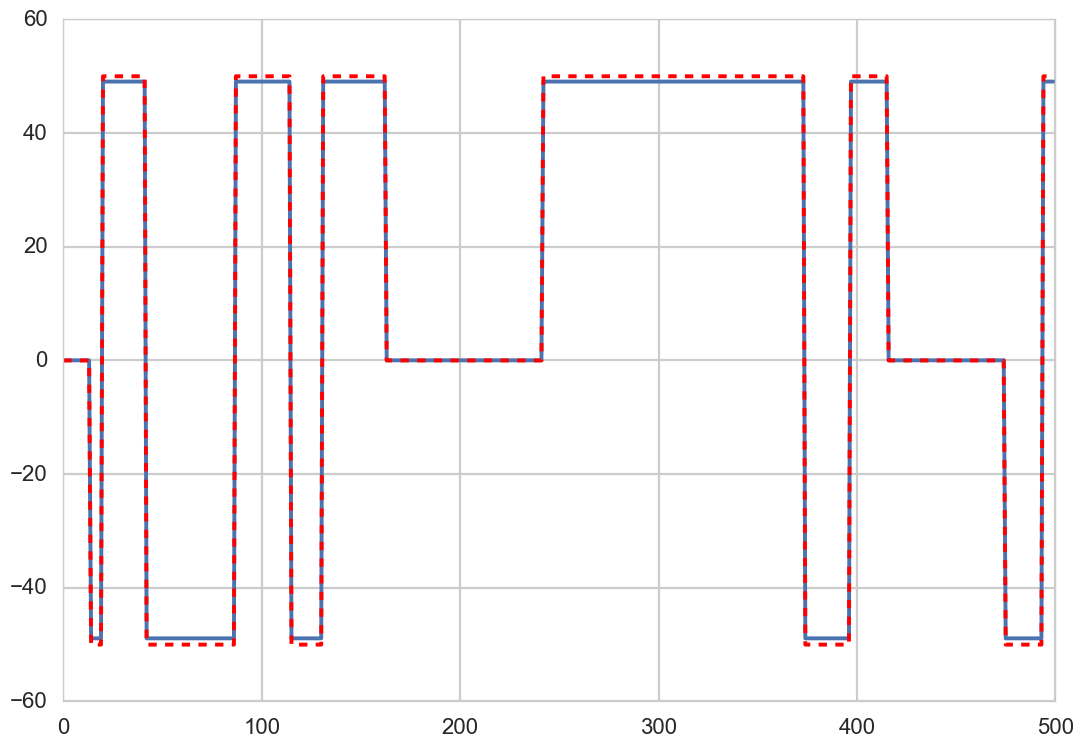

In [1321]:
plt.plot(np.array([a[0] for a in params['theta']])[np.array(z)])
# plt.plot(z, c='g')
# means[np.array(zis, dtype=np.int)]
plt.plot(np.array(means)[np.array(zis, dtype=np.int)], ls='--', c='r')

In [1322]:
params['theta']

[[8.666262777366974, 3.019303135634871],
 [-1.7603497051241406, 4.623764841977133],
 [18.083594779746313, 8.912544393118516],
 [-15.337019836889915, 5.239841721796921],
 [49.06645388982815, 7.720955794338554],
 [0.02221589431610571, 3.1059433999507586],
 [-48.898113724533836, 7.310321994283032],
 [25.024438072647488, 2.037757943336686]]

In [1323]:
z

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,

In [1467]:
import hdp_scripts
import imp
import time
imp.reload(hdp_scripts)

<module 'hdp_scripts' from '/Users/nickhoernle/Harvard/semester_2/bayesian_MIT/project/notebooks/hdp_scripts.py'>

### Define Hamming Distance to use as a comparison metric between the two sets of labels:

In [1468]:
def hamming(seq1, seq2):
    """Calculate the Hamming distance between two bit strings"""
    assert len(seq1) == len(seq2)
    return np.sum(np.array(seq1, dtype=np.int16) != np.array(seq2, dtype=np.int16))

In [1469]:
def match_labels_greedily(seq1, seq2):
    
    seq1 = np.array(seq1, dtype=np.int16)
    seq2 = np.array(seq2, dtype=np.int16)
    
    counts = np.bincount(seq1)
    most_freq = np.argsort(counts)[::-1]
    # what is the argument mapping that we use in this transformation (to recover the original learnt params)
    arg_map = {}
    
    for to_match in most_freq:
        indexes = np.where(seq1 == to_match)[0]
        
        if len(indexes) > 0:
            potential_matches = seq2[indexes]
            counts = np.bincount(potential_matches)
            
            matched = np.argmax(counts)
            
            if matched not in arg_map:
                arg_map[matched] = to_match
            
    to_merge = {}
    for k,v in arg_map.items():
        if v not in arg_map:
            to_merge[v] = k
            
    arg_map = {**arg_map, **to_merge}
    
    for i in range(0, np.max(seq2) + 1):
        if i not in arg_map:
            arg_map[i] = i
    return arg_map

# def relabel_sequence(sequence, theta):
    
#     np.

In [1470]:
update_dict = match_labels_greedily([0,1,1,3,3,3,3], [0,1,1,0,0,0,0])

def update_label(seq1, seq2, theta_params=[]):
    assert(len(seq1) == len(seq2))
    
    update_dict = match_labels_greedily(seq1, seq2)
    new_arr = np.array([update_dict[x] for x in seq2])
    
    new_thetas = np.array([[] for i in range(len(theta_params))])
    if len(theta_params) > 0:

        for i, theta in theta_params:
            new_thetas[update_dict[i]] = theta

    return new_arr, new_thetas

def get_hamming_distance(seq1, seq2):
    
    seq2_updated, sorted_thetas =  update_label(seq1, seq2)
    
    return seq2_updated, sorted_thetas, hamming(seq1, seq2_updated)

In [1471]:
get_hamming_distance(seq1=[0,0,0,1,1,1,0,0,0,0,1,1,1], seq2=[2,2,2,3,3,3,2,2,2,2,3,4,3])

(array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 4, 1]), array([], dtype=float64), 1)

### Run a basic experiment on two sets of params to see the differnce that kappa (sticky param) makes.

In [1525]:
params = {}

# define L=15 components:
L = 15
params['pi'] = np.random.dirichlet(alpha=np.ones(L), size=L)
params['theta'] = [[np.random.normal(0,100), 25] for i in range(L)]
params['L'] = L
params['Y'] = y
params['T'] = len(y)
params['alpha'] = 10
params['beta'] = np.random.dirichlet(np.ones(params['L']))
params['kappa'] = 0
params['gamma'] = 10

num_iter = 100
z = np.zeros_like(y)

for i in range(num_iter):
    start = time.time()
    params, res = hdp_scripts.blocked_Gibbs_for_sticky_HMM_update(y, params, priors=[0,100,1,50])
    seq2_updated, sorted_thetas, hamming_val = get_hamming_distance(seq1=zis, seq2=res)
    z = res
    if i % 10 == 0:
        print("Iteration: %i, time: %0.2f, convegence: %0.3f"%(i, time.time() - start, hamming_val))

params_not_sticky = params
z_not_sticky = z

Iteration: 0, time: 3.26, convegence: 274.000
Iteration: 10, time: 3.10, convegence: 292.000
Iteration: 20, time: 3.21, convegence: 337.000
Iteration: 30, time: 3.26, convegence: 327.000
Iteration: 40, time: 3.07, convegence: 292.000
Iteration: 50, time: 3.28, convegence: 269.000
Iteration: 60, time: 3.26, convegence: 314.000
Iteration: 70, time: 3.28, convegence: 303.000
Iteration: 80, time: 3.02, convegence: 305.000
Iteration: 90, time: 3.36, convegence: 316.000


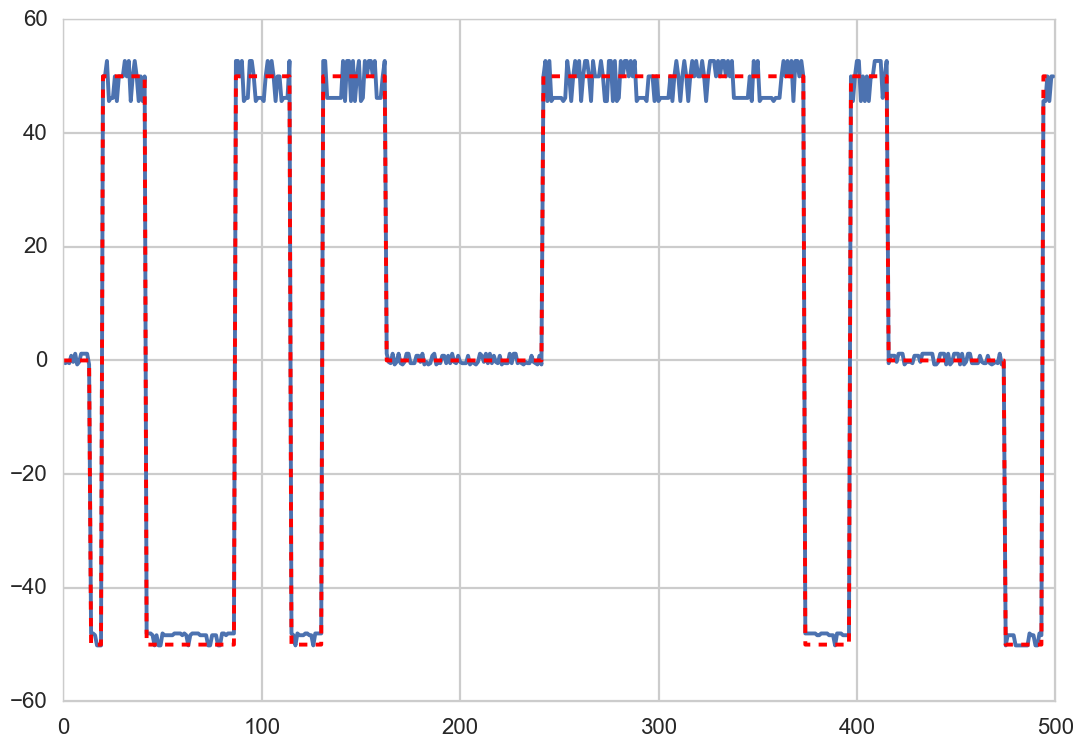

In [1505]:
plt.plot(np.array([a[0] for a in params_not_sticky['theta']])[np.array(z_not_sticky)])
plt.plot(np.array(means)[np.array(zis, dtype=np.int)], ls='--', c='r')


In [1523]:
params = {}

# define L=15 components:
L = 15
params['pi'] = np.random.dirichlet(alpha=np.ones(L), size=L)
params['theta'] = [[np.random.normal(0,100), 25] for i in range(L)]
params['L'] = L
params['Y'] = y
params['T'] = len(y)
params['alpha'] = 10
params['beta'] = np.random.dirichlet(np.ones(params['L']))
params['kappa'] = 100
params['gamma'] = 10

num_iter = 100
z = np.zeros_like(y)

for i in range(num_iter):
    start = time.time()
    params, res = hdp_scripts.blocked_Gibbs_for_sticky_HMM_update(y, params, priors=[0,100,1,50])
    seq2_updated, sorted_thetas, hamming_val = get_hamming_distance(seq1=zis, seq2=res)
    z = res
    if i % 10 == 0:
        print("Iteration: %i, time: %0.2f, convegence: %0.3f"%(i, time.time() - start, hamming_val))

sticky_params = params 
sticky_z = z

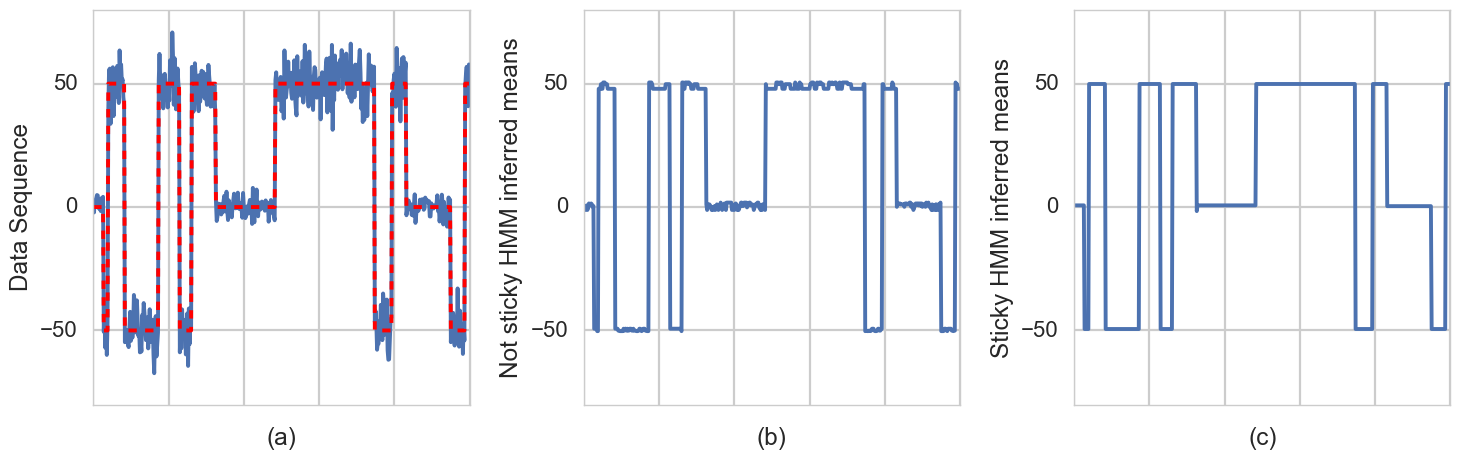

In [1534]:
fig, axes = plt.subplots(1,3,figsize=(15,5))
axes[0].plot(y)
axes[0].plot(np.array(means)[np.array(zis, dtype=np.int)], ls='--', c='r')
axes[1].plot(np.array([a[0] for a in params_not_sticky['theta']])[np.array(z_not_sticky)])
axes[2].plot(np.array([a[0] for a in sticky_params['theta']])[np.array(sticky_z)])

for ax in axes:
    ax.set_ylim([-80,80])
    ax.set_yticks([-50,0,50])
    ax.set_xticklabels([])
    
axes[0].set_ylabel('Data Sequence')
axes[1].set_ylabel('Not sticky HMM inferred means')
axes[2].set_ylabel('Sticky HMM inferred means')

axes[0].set_xlabel('(a)')
axes[1].set_xlabel('(b)')
axes[2].set_xlabel('(c)')

plt.tight_layout()
plt.show()

In [1532]:
len(np.unique(zis)), len(np.unique(z_not_sticky)), len(np.unique(sticky_z))

(3, 15, 5)